# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0

https://drive.google.com/file/d/1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr/view?usp=sharing

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1mm5mq7ngx5D2QHFedjucyUC3z0VDeSRj': 'test_y_labels.npz'       }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)


Mounted at /content/drive


# Data Preprocessing

Here you will implement a pytorch data processor that loads tha images and computes the ground truth labels as described in the PDF.


In [9]:
import numpy as np
from sklearn.model_selection import train_test_split

def loadData(image_path, labels_path):
  ## use 0.8*no_images as the training data and the remaining as test data.
  image = np.load("/content/images.npz",allow_pickle=True)['arr_0']
  label = np.load("/content/labels.npz",allow_pickle=True,encoding = "latin1")['arr_0']
  train_images,test_images,train_raw_lables,test_raw_labels = train_test_split(image, label, test_size=0.20,shuffle=True)
  return train_images, test_images, train_raw_lables, test_raw_labels

def create_y_label(image, raw_label):
  ## this function should compute the 8X8X8 label from the raw labels for the corresponding image.
  y_label = np.zeros((8,8,8))
  for label in raw_label:
    x1,y1,x2,y2 = label[1:]
    center_x = (x1+ x2) / 2 
    center_y = (y1 + y2) / 2
    x_index = int(center_x/16)
    y_index = int(center_y/16)
    offset_x = (center_x %16) / 16
    offset_y = (center_y %16) / 16

    #Finding the width and height 
    w = (x2 - x1)/128
    h = (y2 - y1)/128
    class_label = label[0]
    label_one_hot =np.zeros(3)
    label_one_hot[int(label[0])] = 1
    

    y_label[0:5,x_index,y_index] = [1,offset_x,offset_y,w,h]
    y_label[5:,x_index,y_index] = label_one_hot

  return y_label

In [ ]:
train_images, test_images, train_raw_lables, test_raw_labels = loadData('/content/images.npz', '/content/labels.npz')

TEST your processed y_labels.

The following test checks your create_y_labels function using the test_y_label.npz file.

In [ ]:

data = np.load("test_y_labels.npz",allow_pickle=True)
## the test data contains 5 - (image, raw_label, processed_label) that is 5 test cases 

img = data['image']   ## shape (5,3,128,18)
raw_label = data['raw_label']
true_y_label = data['y_label']  ## shape (5,8,8,8)

## fill in your code to compute the your processed y_label
y_label = np.zeros((5,8,8,8))


for i, label in enumerate(raw_label):
  y_label[i] = create_y_label(img[i], label)



# test you processed labels
for i in range(len(img)):
  # print("Y label",y_label[i])
  # print("Y  true label",true_y_label[i])
  comparison = y_label[i] == true_y_label[i]
  equal_arrays = comparison.all()
  print('Completed TEST CASE {}: {}'.format(i+1,equal_arrays))


Completed TEST CASE 1: True
Completed TEST CASE 2: True
Completed TEST CASE 3: True
Completed TEST CASE 4: True
Completed TEST CASE 5: True


Test your DATASET

Test your data processing by plotting the images and the processed labels. Compare against the raw labels. 

Set up the data set for training and testing.

In [7]:
import torch 
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [10]:
class YOLODataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    self.images = image_file
    self.labels = label_file
    self.transform = transform
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, index):
    sample_image = self.images[index]
    sample_label = self.labels[index]
    
    if self.transform:
      sample_image = self.transform(sample_image)

    sample_image = sample_image.transpose((2,0,1))
    sample_image = torch.tensor(sample_image).type(torch.FloatTensor)
    #new_label = torch.tensor(create_y_label(sample_image,sample_label))
    #print(sample_label)
    #sample_label = torch.tensor(convertLabel(sample_label))
          
    return (sample_image, sample_label)

# 7.2.1

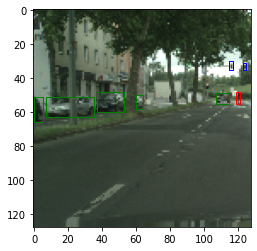

In [ ]:
train_dataset = YOLODataset(train_images, train_raw_lables)
image,new_label = train_dataset.__getitem__(87)
images = image.type(torch.IntTensor).numpy()
images = np.transpose(images,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(images)
for i in range(len(new_label)):
  #For detecting Pedestrian
  if new_label[i][0] == 0:
    rect1 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect1)
    #For detecting Traffic Light
  if raw_label[i][0] == 1:
    rect2 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect2)
    #For detecting Car
  if raw_label[i][0] == 2:
    rect3 = patches.Rectangle((new_label[i][1],new_label[i][2]),(new_label[i][3]-new_label[i][1]),(new_label[i][4]-new_label[i][2]),linewidth=1,edgecolor='g',facecolor='none')
    ax.add_patch(rect3)
        
plt.show()

# 7.2.2

In [ ]:
train_dataset = YOLODataset(train_images, train_raw_lables)
image,label = train_dataset.__getitem__(87)
op = create_y_label(image,label)
for i in range(8):
  op[i] = op[i].T

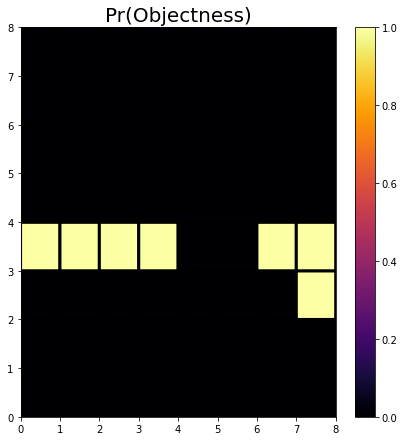

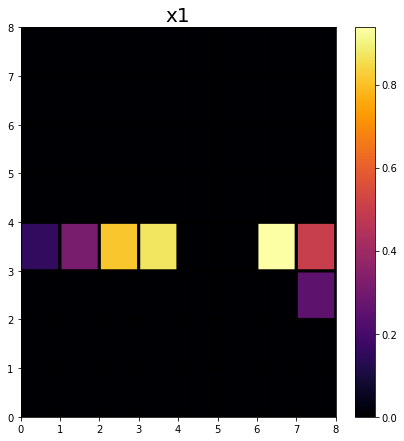

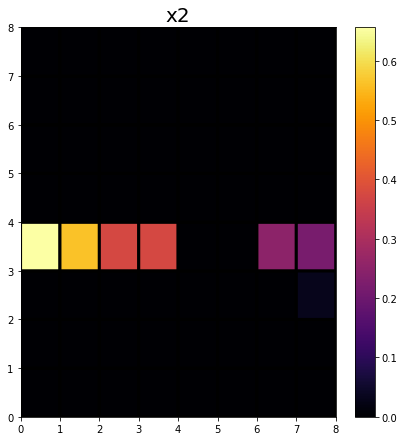

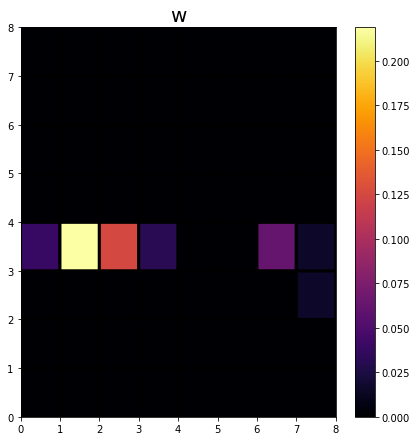

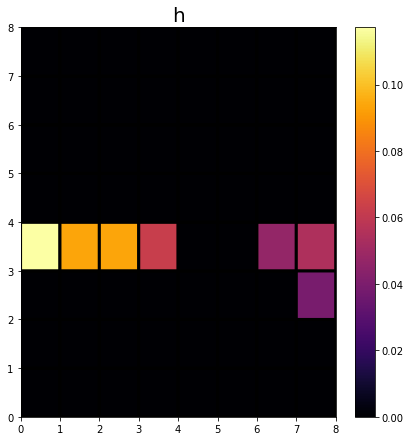

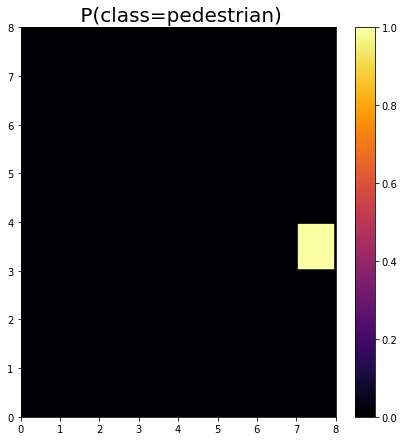

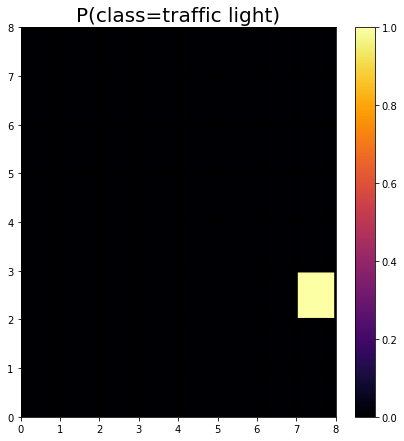

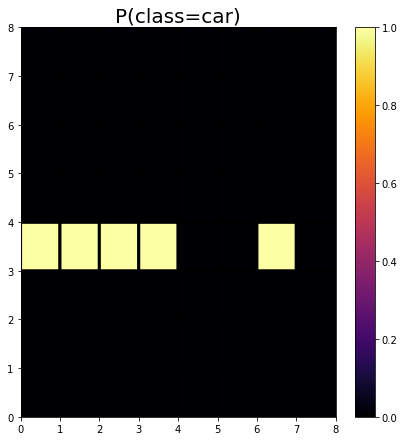

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import colors
Title = ["Pr(Objectness)", "x1","x2","w","h"," P(class=pedestrian)", "P(class=traffic light)", "P(class=car)"]
for i in range(8):
  fig = plt.figure(figsize=(6,6))
  plt.pcolor(op[i],cmap='inferno',edgecolors='k', linewidths=3)
  plt.tight_layout()
  plt.title(Title[i], fontsize=20)
  plt.colorbar()
  plt.show()

# 7.2.3

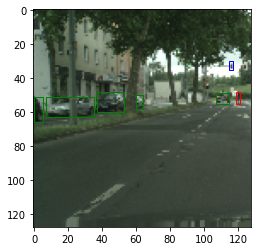

In [ ]:
train_dataset = YOLODataset(train_images, train_raw_lables)
image,label = train_dataset.__getitem__(87)
label1 = create_y_label(image,label)
image = image.type(torch.IntTensor).numpy()
image = np.transpose(image,(1,2,0))
fig,ax = plt.subplots(1)
ax.imshow(image)
for i in range(8):
  label1[i] = label1[i].T

for i in range(8):
  for j in range(8):
    if label1[0][i][j]>0.5:
      if label1[5][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 -width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect1 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect1)
      if label1[6][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect2 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(rect2)
      if label1[7][i][j]>0.5:
        width = label1[3][i][j]*128
        height = label1[4][i][j]*128
        xcoord = label1[1][i][j]*16 + j*16 - width/2
        ycoord = label1[2][i][j]*16 + i*16 - height/2
        rect3 = patches.Rectangle((xcoord,ycoord),width,height,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(rect3)
        
plt.show()

# Model Definition

In [29]:
class YOLO(torch.nn.Module):
  def __init__(self):
    super(YOLO, self).__init__()
    self.convolution1 = nn.Conv2d(3, 32,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm1 = nn.BatchNorm2d(32)
    
    self.convolution2 = nn.Conv2d(32, 64,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm2 = nn.BatchNorm2d(64)
    
    self.convolution3 = nn.Conv2d(64, 128,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm3 = nn.BatchNorm2d(128)
    
    self.convolution4 = nn.Conv2d(128, 256,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm4 = nn.BatchNorm2d(256)
    
    self.convolution5 = nn.Conv2d(256, 512,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm5 = nn.BatchNorm2d(512)
    
    self.convolution6 = nn.Conv2d(512, 1024,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm6 = nn.BatchNorm2d(1024)
    
    self.convolution7 = nn.ConvTranspose2d(1024,256,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm7 = nn.BatchNorm2d(256)
    
    self.convolution8 = nn.ConvTranspose2d(256, 64,
                              kernel_size=4,
                              stride=2, padding = (1,1))
    self.batchnorm8 = nn.BatchNorm2d(64)
    
    self.convolution9 = nn.Conv2d(64, 8,
                              kernel_size=3,
                              stride=1, padding = (1,1))
      
  def forward(self, x):
    
    x = F.relu(self.batchnorm1(self.convolution1(x.float())))
    x = F.relu(self.batchnorm2(self.convolution2(x)))
    x = F.relu(self.batchnorm3(self.convolution3(x)))
    x = F.relu(self.batchnorm4(self.convolution4(x)))
    x = F.relu(self.batchnorm5(self.convolution5(x)))
    x = F.relu(self.batchnorm6(self.convolution6(x)))
    x = F.relu(self.batchnorm7(self.convolution7(x)))
    x = F.relu(self.batchnorm8(self.convolution8(x)))
    x = torch.sigmoid(self.convolution9(x))
      
    return x



# Training you network

Start by defining the 
1. IOU
2. appropropriate loss function.
3. NMS - non-max suppression function
4. Average precision function

Please define additional functions as needed.

In [30]:
def decode_box(code,objects):
  box = torch.zeros(4)
  x,y,w,h = code[1:5]
  re_w=w*128
  re_h=h*128
  re_x=x*16
  re_y=y*16
  grid_x = objects[1]
  grid_y = objects[2]
  box[0] = grid_x *16 + re_x -re_w/2
  box[1] = grid_y *16 + re_y -re_h/2
  box[2] = grid_x *16 + re_x  + re_w/2
  box[3] = grid_y *16 + re_y  + re_h/2
  return box



def IOU(bbox_1, bbox_2):
   ## please fill in additional arguements
   x_1up = bbox_1[0]
   y_1up = bbox_1[1]
   x_11 = bbox_1[2]
   y_11 = bbox_1[3]
   
   x_2up = bbox_2[0]
   y_2up = bbox_2[1]
   x_21 = bbox_2[2]
   y_21 = bbox_2[3]

   x_up = max(x_1up,x_2up)
   y_up = max(y_1up,y_2up)
   x_1 = min(x_11,x_21)
   y_1 = min(y_11,y_21)
   
   inter_area = max((x_1 - x_up + 1),0) * max((y_1 - y_up + 1),0)
   area_box1 = (x_11 - x_1up + 1) * (y_11 - y_1up + 1)
   area_box2 = (x_21 - x_2up + 1) * (y_21 - y_2up + 1)
   union_area = area_box1 + area_box2 - inter_area 
   iou = inter_area / union_area
   return iou

def calc_confidence_score(prediction, grnd_truth,objects):
  ## please fill in additional arguements
  num_objects = prediction.shape[0]
  C_true = torch.zeros(num_objects)
  #predicted_bbox = prediction.shape[0]
  #grnd_truth_bbox = torch.zeros(num_objects)
  for i in range(num_objects):
    predicted_bbox = decode_box(prediction[i,:],objects[i,:])
    grnd_truth_bbox = decode_box(grnd_truth[i,:],objects[i,:])
    iou = IOU(predicted_bbox,grnd_truth_bbox)
    C_true[i] = iou
  ## this iou is the target/ground truth box confidence score for the grid cell where there is an object
  ## when no object is present this confidence score is 0.
  ## use this C_true for computing the confidence loss.
  return C_true



def YoloLoss(outputs, target, lambda_coord, lambda_noobj):
  objects = target[:,0,:,:].nonzero()
  non_objects = (target[:,0,:,:]==0).nonzero()
  target_objects=target[objects[:,0],:,objects[:,1],objects[:,2]]
  predicted_objects=outputs[objects[:,0],:,objects[:,1],objects[:,2]]
  loc1_c = torch.sum(target[:,0,:,:]*((target[:,1,:,:] - outputs[:,1,:,:])**2 + (target[:,2,:,:] - outputs[:,2,:,:])**2))
  loc1_w = torch.sum(target[:,0,:,:]*((torch.sqrt(target[:,3,:,:]) - torch.sqrt(outputs[:,3,:,:]))**2 + (torch.sqrt(target[:,4,:,:]) - torch.sqrt(outputs[:,4,:,:]))**2)) 
  conf = calc_confidence_score(predicted_objects,target_objects,objects)
  loss_conf_object = torch.sum((conf[:].cuda()-predicted_objects[:,0].cuda())**2) 
  loss_conf_no_object = torch.sum((0-predicted_objects[:,0])**2)
  loss_class = torch.sum(target[:,0,:,:]*((target[:,5,:,:] - outputs[:,5,:,:])**2 + (target[:,6,:,:] - outputs[:,6,:,:])**2 + (target[:,7,:,:] - outputs[:,7,:,:])**2))
  loss = lambda_coord*(loc1_c+loc1_w) + loss_conf_object + (lambda_noobj * loss_conf_no_object) + loss_class
  return loss




In [31]:

import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/drive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz',
    '1tkpFDxbpP61OEic7EP4LOhUKclYJLlwr': 'test_y_label.npz', 
    '1wuDhxLk2QAmvio-iGVUyLWZbp8DfY8OI': 'test_yolo_loss.npz'     }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)



import numpy as np
import pdb
import torch

#path = os.path.join(HOMEWORK_FOLDER,'test_yolo_loss.npz')
data = np.load('test_yolo_loss.npz',allow_pickle=True)

## the test data contains 10 - (predicted_ouput, target, true_loss) that is 10 test cases 

predicted = data['pred']   ## shape (10,1,8,8,8)
target = data['target']   ## shape (10,1,8,8,8)
true_loss = data['loss']  ## shape (10,)

for i  in range(len(predicted)):
  computed_loss = YoloLoss(torch.from_numpy(predicted[i,:,:,:,:]), torch.from_numpy(target[i,:,:,:,:]), 5, 0.5)
  print('TEST CASE {}: Computed Loss - {} Loss - {}'.format(i+1,computed_loss, true_loss[i]))






Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:71: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)


TEST CASE 1: Computed Loss - 8.638099670410156 Loss - 8.570581859398414
TEST CASE 2: Computed Loss - 6.854546546936035 Loss - 6.800624567771324
TEST CASE 3: Computed Loss - 9.870726585388184 Loss - 9.830386627684668
TEST CASE 4: Computed Loss - 8.135767936706543 Loss - 8.104469495911465
TEST CASE 5: Computed Loss - 9.580194473266602 Loss - 9.56554696444006
TEST CASE 6: Computed Loss - 5.269013404846191 Loss - 5.181439780422893
TEST CASE 7: Computed Loss - 1.6634485721588135 Loss - 1.6365162407967868
TEST CASE 8: Computed Loss - 7.263216018676758 Loss - 7.215272422683144
TEST CASE 9: Computed Loss - 5.722009658813477 Loss - 5.683797272216336
TEST CASE 10: Computed Loss - 8.79401969909668 Loss - 8.74894558115439


**Train your network **

We suggest that you save checkpoints sand reload from the most recent. This is due time constraints within Colab


In [32]:
import torch, torchvision
import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import torch.optim as optim

In [ ]:

class YOLODataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    self.images = image_file
    self.labels = label_file
    self.transform = self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, index):
    new_image = self.images[index]
    new_label = self.labels[index]
    
    if self.transform:
      new_image = self.transform(new_image)
    new_label = torch.tensor(create_y_label(new_image,new_label))
  
    return (new_image, new_label)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=YOLODataset(train_images, train_raw_lables),batch_size = 64, shuffle = True)
yolo_net=YOLO()
device = torch.device("cuda:0")
yolo_net=yolo_net.cuda()
learning_rate = 10e-3 

In [ ]:
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=0.001,weight_decay=0.0006)


In [37]:
lambda_coord = torch.Tensor([5]).to(device)
lambda_noobj = torch.Tensor([0.5]).to(device)

In [ ]:
training_loss = []
epoc = []

In [ ]:
def train(net, optimizer, train_loader,epochs):
    overall_step = 0
    
    
    for epoch in tqdm.tqdm(range(epochs)):
      net.train()
      net.to(device)
      train_loss = 0
      for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        #images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = YoloLoss(outputs, labels,lambda_coord.cuda(),lambda_noobj.cuda()).cuda()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
      training_loss.append(train_loss /(i+1))
      print("Training Loss", train_loss / (i+1))
      epoc.append(epoch)
      path = os.path.join('','yolo_epoc'+str(epoch))
      torch.save({
                'epoch': epoch,
                'model_state_dict': yolo_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, path)

      #  print(f' \ntrain images {train_loss / len(train_loader)}')

    return training_loss

In [ ]:
train(yolo_net, optimizer, train_loader,20)


  0%|          | 0/20 [00:00<?, ?it/s]

Training Loss 338.4824794921875



  5%|▌         | 1/20 [01:08<21:46, 68.76s/it]

Training Loss 277.4431334228516



 10%|█         | 2/20 [02:17<20:36, 68.72s/it]

Training Loss 238.71518041992186



 15%|█▌        | 3/20 [03:25<19:26, 68.63s/it]

Training Loss 219.71446936035156



 20%|██        | 4/20 [04:34<18:17, 68.57s/it]

Training Loss 201.15605480957032



 25%|██▌       | 5/20 [05:42<17:09, 68.62s/it]

Training Loss 185.15772094726563



 30%|███       | 6/20 [06:52<16:04, 68.88s/it]

Training Loss 166.27452770996095



 35%|███▌      | 7/20 [08:01<14:57, 69.06s/it]

Training Loss 145.18265338134765



 40%|████      | 8/20 [09:11<13:50, 69.18s/it]

Training Loss 125.6198663330078



 45%|████▌     | 9/20 [10:20<12:41, 69.26s/it]

Training Loss 104.81550201416016



 50%|█████     | 10/20 [11:30<11:33, 69.35s/it]

Training Loss 88.93587182617188



 55%|█████▌    | 11/20 [12:39<10:24, 69.41s/it]

Training Loss 77.45057580566406



 60%|██████    | 12/20 [13:49<09:16, 69.51s/it]

Training Loss 68.0871618347168



 65%|██████▌   | 13/20 [14:59<08:06, 69.55s/it]

Training Loss 61.92765634155273



 70%|███████   | 14/20 [16:09<06:58, 69.76s/it]

Training Loss 58.20695178222656



 75%|███████▌  | 15/20 [17:20<05:50, 70.06s/it]

Training Loss 55.096061737060545



 80%|████████  | 16/20 [18:30<04:40, 70.17s/it]

Training Loss 52.050148071289065



 85%|████████▌ | 17/20 [19:40<03:30, 70.11s/it]

Training Loss 49.9868821105957



 90%|█████████ | 18/20 [20:50<02:20, 70.05s/it]

Training Loss 47.99882083129883



 95%|█████████▌| 19/20 [22:00<01:10, 70.12s/it]

Training Loss 46.85792004394531



100%|██████████| 20/20 [23:11<00:00, 69.55s/it]


[338.4824794921875,
 277.4431334228516,
 238.71518041992186,
 219.71446936035156,
 201.15605480957032,
 185.15772094726563,
 166.27452770996095,
 145.18265338134765,
 125.6198663330078,
 104.81550201416016,
 88.93587182617188,
 77.45057580566406,
 68.0871618347168,
 61.92765634155273,
 58.20695178222656,
 55.096061737060545,
 52.050148071289065,
 49.9868821105957,
 47.99882083129883,
 46.85792004394531]

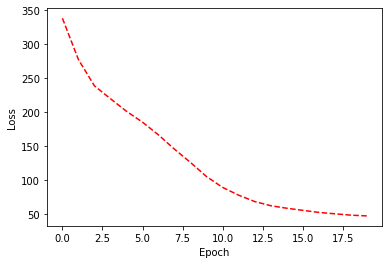

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epoc, training_loss, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Normalized More Epochs and different learning rate 10e-5

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=YOLODataset(train_images, train_raw_lables),batch_size = 64, shuffle = True)
yolo_net=YOLO()
device = torch.device("cuda:0")
yolo_net=yolo_net.cuda()
learning_rate = 10e-5
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=0.001,weight_decay=0.0006)
training_loss = []
epoc = []

In [ ]:
train(yolo_net, optimizer, train_loader,70)


  0%|          | 0/70 [00:00<?, ?it/s]

Training Loss 363.768302734375



  1%|▏         | 1/70 [01:16<1:28:27, 76.92s/it]

Training Loss 261.4693897705078



  3%|▎         | 2/70 [02:34<1:27:18, 77.03s/it]

Training Loss 165.73312829589844



  4%|▍         | 3/70 [03:50<1:25:50, 76.88s/it]

Training Loss 105.91998010253906



  6%|▌         | 4/70 [05:07<1:24:24, 76.73s/it]

Training Loss 80.33988525390625



  7%|▋         | 5/70 [06:23<1:22:55, 76.55s/it]

Training Loss 68.4011750793457



  9%|▊         | 6/70 [07:39<1:21:40, 76.57s/it]

Training Loss 59.66570837402344



 10%|█         | 7/70 [08:56<1:20:17, 76.47s/it]

Training Loss 54.1959912109375



 11%|█▏        | 8/70 [10:12<1:18:53, 76.35s/it]

Training Loss 50.840084014892575



 13%|█▎        | 9/70 [11:28<1:17:28, 76.21s/it]

Training Loss 48.739354217529296



 14%|█▍        | 10/70 [12:44<1:16:13, 76.23s/it]

Training Loss 46.93278231811524



 16%|█▌        | 11/70 [14:00<1:14:54, 76.18s/it]

Training Loss 45.514030029296876



 17%|█▋        | 12/70 [15:16<1:13:33, 76.09s/it]

Training Loss 44.5013268737793



 19%|█▊        | 13/70 [16:32<1:12:14, 76.04s/it]

Training Loss 43.57973318481445



 20%|██        | 14/70 [17:48<1:11:02, 76.12s/it]

Training Loss 42.764539825439456



 21%|██▏       | 15/70 [19:04<1:09:49, 76.16s/it]

Training Loss 42.24668441772461



 23%|██▎       | 16/70 [20:21<1:08:34, 76.20s/it]

Training Loss 41.67566567993164



 24%|██▍       | 17/70 [21:37<1:07:18, 76.20s/it]

Training Loss 40.87099722290039



 26%|██▌       | 18/70 [22:54<1:06:13, 76.41s/it]

Training Loss 40.46856607055664



 27%|██▋       | 19/70 [24:10<1:05:02, 76.53s/it]

Training Loss 40.1327370300293



 29%|██▊       | 20/70 [25:27<1:03:48, 76.57s/it]

Training Loss 39.689321228027346



 30%|███       | 21/70 [26:43<1:02:24, 76.42s/it]

Training Loss 39.264650238037106



 31%|███▏      | 22/70 [27:59<1:01:02, 76.30s/it]

Training Loss 38.78890661621094



 33%|███▎      | 23/70 [29:16<59:47, 76.33s/it]  

Training Loss 38.31905596923828



 34%|███▍      | 24/70 [30:32<58:26, 76.23s/it]

Training Loss 38.298421234130856



 36%|███▌      | 25/70 [31:48<57:07, 76.17s/it]

Training Loss 37.988606658935545



 37%|███▋      | 26/70 [33:04<55:51, 76.17s/it]

Training Loss 37.71734536743164



 39%|███▊      | 27/70 [34:19<54:26, 75.96s/it]

Training Loss 37.37714880371094



 40%|████      | 28/70 [35:34<52:59, 75.71s/it]

Training Loss 37.01641897583008



 41%|████▏     | 29/70 [36:50<51:46, 75.77s/it]

Training Loss 36.904382293701175



 43%|████▎     | 30/70 [38:10<51:19, 76.99s/it]

Training Loss 36.75805047607422



 44%|████▍     | 31/70 [39:29<50:25, 77.58s/it]

Training Loss 36.66643211364746



 46%|████▌     | 32/70 [40:48<49:21, 77.92s/it]

Training Loss 36.54807682800293



 47%|████▋     | 33/70 [42:07<48:11, 78.14s/it]

Training Loss 36.587403549194335



 49%|████▊     | 34/70 [43:25<46:53, 78.16s/it]

Training Loss 36.27343348693848



 50%|█████     | 35/70 [44:42<45:30, 78.01s/it]

Training Loss 36.15226725769043



 51%|█████▏    | 36/70 [46:00<44:07, 77.87s/it]

Training Loss 36.24437329101563



 53%|█████▎    | 37/70 [47:17<42:46, 77.78s/it]

Training Loss 36.18055207824707



 54%|█████▍    | 38/70 [48:35<41:27, 77.74s/it]

Training Loss 36.00242599487305



 56%|█████▌    | 39/70 [49:53<40:13, 77.85s/it]

Training Loss 35.54080107116699



 57%|█████▋    | 40/70 [51:11<38:56, 77.90s/it]

Training Loss 35.233437225341795



 59%|█████▊    | 41/70 [52:29<37:40, 77.94s/it]

Training Loss 35.16902279663086



 60%|██████    | 42/70 [53:47<36:17, 77.77s/it]

Training Loss 35.16364152526855



 61%|██████▏   | 43/70 [54:59<34:18, 76.25s/it]

Training Loss 35.118868087768554



 63%|██████▎   | 44/70 [56:13<32:38, 75.33s/it]

Training Loss 34.69296369934082



 64%|██████▍   | 45/70 [57:26<31:09, 74.76s/it]

Training Loss 34.17684033203125



 66%|██████▌   | 46/70 [58:40<29:46, 74.43s/it]

Training Loss 34.16598207092285



 67%|██████▋   | 47/70 [59:53<28:21, 74.00s/it]

Training Loss 34.4301309967041



 69%|██████▊   | 48/70 [1:01:05<26:57, 73.54s/it]

Training Loss 43.530526123046876



 70%|███████   | 49/70 [1:02:18<25:37, 73.23s/it]

Training Loss 65.66982064819337



 71%|███████▏  | 50/70 [1:03:30<24:19, 72.99s/it]

Training Loss 52.08317953491211



 73%|███████▎  | 51/70 [1:04:43<23:04, 72.85s/it]

Training Loss 40.70739013671875



 74%|███████▍  | 52/70 [1:05:55<21:48, 72.70s/it]

Training Loss 35.771351226806644



 76%|███████▌  | 53/70 [1:07:07<20:33, 72.55s/it]

Training Loss 33.40816856384277



 77%|███████▋  | 54/70 [1:08:19<19:19, 72.47s/it]

Training Loss 32.347065246582034



 79%|███████▊  | 55/70 [1:09:32<18:06, 72.42s/it]

Training Loss 31.900791625976563



 80%|████████  | 56/70 [1:10:44<16:53, 72.39s/it]

Training Loss 31.613615646362305



 81%|████████▏ | 57/70 [1:11:56<15:40, 72.34s/it]

Training Loss 31.56848826599121



 83%|████████▎ | 58/70 [1:13:09<14:28, 72.34s/it]

Training Loss 31.39718782043457



 84%|████████▍ | 59/70 [1:14:21<13:15, 72.30s/it]

Training Loss 31.33177426147461



 86%|████████▌ | 60/70 [1:15:33<12:04, 72.41s/it]

Training Loss 31.399865158081056



 87%|████████▋ | 61/70 [1:16:47<10:54, 72.67s/it]

Training Loss 31.355835250854494



 89%|████████▊ | 62/70 [1:17:59<09:39, 72.50s/it]

Training Loss 31.32576268005371



 90%|█████████ | 63/70 [1:19:11<08:26, 72.36s/it]

Training Loss 31.426707550048828



 91%|█████████▏| 64/70 [1:20:23<07:14, 72.36s/it]

Training Loss 31.62218000793457



 93%|█████████▎| 65/70 [1:21:35<06:01, 72.29s/it]

Training Loss 31.878828216552733



 94%|█████████▍| 66/70 [1:22:48<04:49, 72.27s/it]

Training Loss 31.792303817749023



 96%|█████████▌| 67/70 [1:24:00<03:36, 72.29s/it]

Training Loss 31.725135986328127



 97%|█████████▋| 68/70 [1:25:12<02:24, 72.30s/it]

Training Loss 31.818549728393556



 99%|█████████▊| 69/70 [1:26:25<01:12, 72.49s/it]

Training Loss 31.82358609008789



100%|██████████| 70/70 [1:27:39<00:00, 75.13s/it]


[338.4824794921875,
 277.4431334228516,
 238.71518041992186,
 219.71446936035156,
 201.15605480957032,
 185.15772094726563,
 166.27452770996095,
 145.18265338134765,
 125.6198663330078,
 104.81550201416016,
 88.93587182617188,
 77.45057580566406,
 68.0871618347168,
 61.92765634155273,
 58.20695178222656,
 55.096061737060545,
 52.050148071289065,
 49.9868821105957,
 47.99882083129883,
 46.85792004394531]

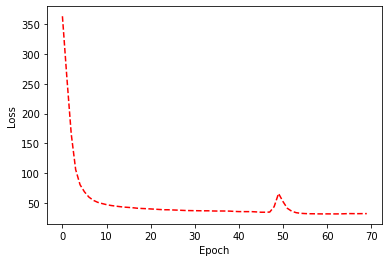

In [ ]:
#70 epochs with Normalization 
plt.plot(epoc_norm, training_loss_norm, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Non-Normalized and more epochs


In [35]:
class YOLONormDataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    self.images = image_file
    self.labels = label_file

  def __len__(self):
    return len(self.labels)
    
  def __getitem__(self, index):
    new_image = self.images[index]
    new_label = self.labels[index]
    
    
    new_label = torch.tensor(create_y_label(new_image,new_label))
  
    return (new_image, new_label)

In [36]:
train_loader = torch.utils.data.DataLoader(dataset=YOLONormDataset(train_images, train_raw_lables),batch_size = 64, shuffle = True)

yolo_net=YOLO()
device = torch.device("cuda:0")
yolo_net=yolo_net.cuda()


In [ ]:
optimizer=torch.optim.Adam(yolo_net.parameters(),lr=10e-5,weight_decay=0.0006)


In [ ]:
training_loss_norm = []
epoc_norm = []

In [ ]:
def train(net, optimizer, train_loader,epochs):
    overall_step = 0
    
    
    for epoch in tqdm.tqdm(range(epochs)):
      net.train()
      net.to(device)
      train_loss = 0
      for i, (images, labels) in enumerate(train_loader):
        images = images.cuda()
        labels = labels.cuda()
        images = images.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        outputs = net(images)
        loss = YoloLoss(outputs, labels,lambda_coord.cuda(),lambda_noobj.cuda()).cuda()
        #print("INtermittent LOss", loss/(i+1))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
      training_loss_norm.append(train_loss /(i+1))
      print("Training Loss", train_loss / (i+1))
      epoc_norm.append(epoch)
      path = os.path.join('','yolo_norm_epoc'+str(epoch))
      torch.save({
                'epoch': epoch,
                'model_state_dict': yolo_net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, path)

      #  print(f' \ntrain images {train_loss / len(train_loader)}')

    return training_loss

In [ ]:
train(yolo_net, optimizer, train_loader,50)


  0%|          | 0/50 [00:00<?, ?it/s]

Training Loss 359.3986450195313



  2%|▏         | 1/50 [01:15<1:01:28, 75.27s/it]

Training Loss 254.1849598388672



  4%|▍         | 2/50 [02:31<1:00:21, 75.44s/it]

Training Loss 162.4098180541992



  6%|▌         | 3/50 [03:46<59:06, 75.46s/it]  

Training Loss 104.4099691772461



  8%|▊         | 4/50 [05:02<57:50, 75.45s/it]

Training Loss 79.11421496582031



 10%|█         | 5/50 [06:17<56:31, 75.37s/it]

Training Loss 65.41761239624023



 12%|█▏        | 6/50 [07:32<55:16, 75.37s/it]

Training Loss 58.21434429931641



 14%|█▍        | 7/50 [08:47<53:57, 75.30s/it]

Training Loss 53.644132629394534



 16%|█▌        | 8/50 [10:02<52:34, 75.12s/it]

Training Loss 50.85198934936523



 18%|█▊        | 9/50 [11:17<51:22, 75.18s/it]

Training Loss 48.361186004638675



 20%|██        | 10/50 [12:33<50:14, 75.36s/it]

Training Loss 46.98525897216797



 22%|██▏       | 11/50 [13:48<48:55, 75.28s/it]

Training Loss 45.65297503662109



 24%|██▍       | 12/50 [15:03<47:35, 75.16s/it]

Training Loss 44.854537414550784



 26%|██▌       | 13/50 [16:17<46:12, 74.93s/it]

Training Loss 43.673679901123045



 28%|██▊       | 14/50 [17:32<44:53, 74.82s/it]

Training Loss 42.97524722290039



 30%|███       | 15/50 [18:47<43:39, 74.84s/it]

Training Loss 42.08205743408203



 32%|███▏      | 16/50 [20:02<42:25, 74.86s/it]

Training Loss 41.84024984741211



 34%|███▍      | 17/50 [21:17<41:10, 74.87s/it]

Training Loss 40.656524536132814



 36%|███▌      | 18/50 [22:32<39:56, 74.90s/it]

Training Loss 40.458023742675785



 38%|███▊      | 19/50 [23:46<38:36, 74.72s/it]

Training Loss 40.22499188232422



 40%|████      | 20/50 [25:00<37:16, 74.56s/it]

Training Loss 39.475101348876954



 42%|████▏     | 21/50 [26:14<35:58, 74.44s/it]

Training Loss 38.944489471435546



 44%|████▍     | 22/50 [27:27<34:32, 74.02s/it]

Training Loss 38.75115487670899



 46%|████▌     | 23/50 [28:41<33:15, 73.90s/it]

Training Loss 38.38265048217774



 48%|████▊     | 24/50 [29:54<31:51, 73.51s/it]

Training Loss 38.09768099975586



 50%|█████     | 25/50 [31:06<30:30, 73.22s/it]

Training Loss 38.08618872070313



 52%|█████▏    | 26/50 [32:19<29:13, 73.05s/it]

Training Loss 37.98798587036133



 54%|█████▍    | 27/50 [33:32<27:58, 72.99s/it]

Training Loss 37.736977508544925



 56%|█████▌    | 28/50 [34:44<26:42, 72.86s/it]

Training Loss 37.26684423828125



 58%|█████▊    | 29/50 [35:57<25:28, 72.80s/it]

Training Loss 36.795729660034176



 60%|██████    | 30/50 [37:09<24:11, 72.60s/it]

Training Loss 36.73463800048828



 62%|██████▏   | 31/50 [38:21<22:55, 72.41s/it]

Training Loss 36.933122222900394



 64%|██████▍   | 32/50 [39:33<21:40, 72.27s/it]

Training Loss 36.923436294555664



 66%|██████▌   | 33/50 [40:45<20:27, 72.18s/it]

Training Loss 36.848327011108395



 68%|██████▊   | 34/50 [41:57<19:15, 72.21s/it]

Training Loss 36.43327024841309



 70%|███████   | 35/50 [43:09<18:03, 72.25s/it]

Training Loss 36.08682551574707



 72%|███████▏  | 36/50 [44:23<16:58, 72.73s/it]

Training Loss 36.08781988525391



 74%|███████▍  | 37/50 [45:38<15:52, 73.28s/it]

Training Loss 36.00218685913086



 76%|███████▌  | 38/50 [46:52<14:41, 73.45s/it]

Training Loss 35.764647888183596



 78%|███████▊  | 39/50 [48:05<13:28, 73.54s/it]

Training Loss 35.71228700256348



 80%|████████  | 40/50 [49:19<12:16, 73.67s/it]

Training Loss 35.403082763671875



 82%|████████▏ | 41/50 [50:33<11:03, 73.71s/it]

Training Loss 34.96015800476074



 84%|████████▍ | 42/50 [51:47<09:50, 73.77s/it]

Training Loss 34.76625633239746



 86%|████████▌ | 43/50 [53:01<08:36, 73.74s/it]

Training Loss 34.39458882141113



 88%|████████▊ | 44/50 [54:14<07:22, 73.69s/it]

Training Loss 34.215498031616214



 90%|█████████ | 45/50 [55:28<06:08, 73.68s/it]

Training Loss 34.18305329895019



 92%|█████████▏| 46/50 [56:42<04:55, 73.78s/it]

Training Loss 34.07585989379883



 94%|█████████▍| 47/50 [57:56<03:41, 73.82s/it]

Training Loss 33.73281631469727



 96%|█████████▌| 48/50 [59:09<02:27, 73.65s/it]

Training Loss 33.936209487915036



 98%|█████████▊| 49/50 [1:00:22<01:13, 73.53s/it]

Training Loss 34.00432250976562



100%|██████████| 50/50 [1:01:38<00:00, 73.97s/it]


[338.4824794921875,
 277.4431334228516,
 238.71518041992186,
 219.71446936035156,
 201.15605480957032,
 185.15772094726563,
 166.27452770996095,
 145.18265338134765,
 125.6198663330078,
 104.81550201416016,
 88.93587182617188,
 77.45057580566406,
 68.0871618347168,
 61.92765634155273,
 58.20695178222656,
 55.096061737060545,
 52.050148071289065,
 49.9868821105957,
 47.99882083129883,
 46.85792004394531]

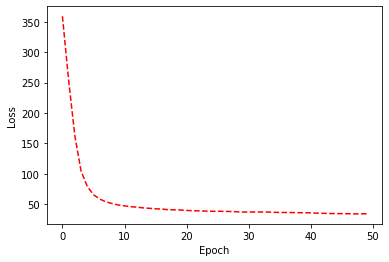

In [ ]:

plt.plot(epoc_norm, training_loss_norm, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()